In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pubchempy as pcp
import numpy as np
import glob
from moleculegraph.molecule_utils import *
from moleculegraph.funcs import *
import moleculegraph
import scipy
import os

In [2]:
options = {
    "node_size": 2000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
    #"with_labels":True,
    "alpha":.3,
    "font_size":16,
}

def vis_mol(bond_list):
    graph  = nx.Graph()
    for b0,b1 in bond_list:
        graph.add_edge(b0-1,b1-1)
        
    labels = {}
    nx.draw_networkx(graph, **options)
    nx.draw_networkx_labels(graph, nx.spring_layout(graph) , labels, font_size=12, font_color="black")

    # Set margins for the axes so that nodes aren't clipped
    ax = plt.gca()
    ax.margins(0.20)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    return

def adjust_bond_list_indexes(bond_list):
    old = np.unique(bond_list)
    new = np.arange(old.size)
    new_list = np.ones( bond_list.shape )*-1
    for i,j in zip(old,new):
        new_list[ bond_list == i ] = j             #überschreibe eintrag mit wert aus vektor
    return new_list,old


def assign_coos_via_distance_mat_local(coos_list,distance_matrix,atom_names,reference_matrix,reference_names):
    """
    Assigns coos to suit a reference based on a distance matrix relying to the coos.
    Reference and distance matrix/ coos belong to the same molecule type but are sorted in
    different ways.
    
    Args:
        coos_list: 
            - list of coordinates.
        distance_matrix:
            - distance matrix which belongs to the coos_list.
        atom_names:
            - names of the atoms corresponding to coos_list.
        reference_matrix:
            - distance matrix which belongs to the reference you want to apply the coos to.
        reference_names:
            - names of the reference molecule.
            
    Returns:
        new_coos_list:
            - list of coordinates fitting the reference.
        idx:
            - indexes to translate sth. to reference.
    """

    
    distance_matrix_sort = np.sort(distance_matrix,axis=1)
    reference_sort = np.sort(reference_matrix,axis=1)
    idx = []
    
    for rm,rn in zip(reference_sort,reference_names):
        for i,(row,nn) in enumerate(zip(distance_matrix_sort,atom_names)):
            if np.array_equal(rm, row) and i not in idx and nn in rn:
                idx.append(i)
                break
            
    idx = np.array(idx)
    
    print("""\n\nWARNING:
    Assign_coos_via_distance_mat is not mature yet.
    Double-check your results!!! \n \n""")
    
    return coos_list[idx], idx 

In [3]:
Gruppe   = "Mixtures"
name_mix = "hexane_butylamine"

name1   = "butylamine"
smiles1 = "CCCCN"
molecule1_graphstring = "[CH3_alkane][CH2_alkane][CH2_alkane][CH2_amine][NH2_amine][b1][cH_amine][cH_amine]"

name2   = "hexane"
smiles2 = "CCCCCC"
molecule2_graphstring = "[CH3_alkane][CH2_alkane][CH2_alkane][CH2_alkane][CH2_alkane][CH3_alkane]"


dict_key = "343"

name_list = [name1,name2]


Molecule: butylamine


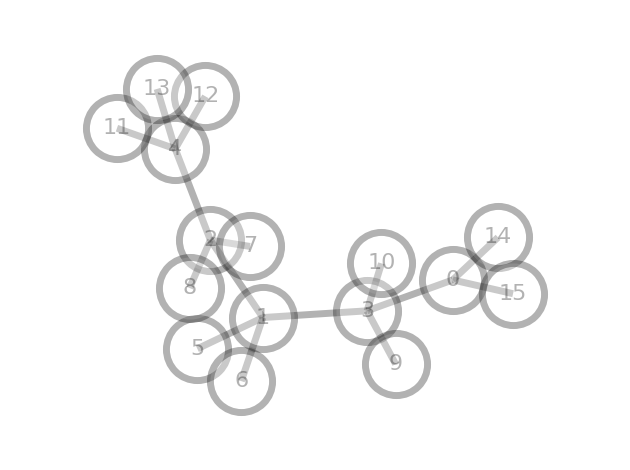

Molecule: hexane


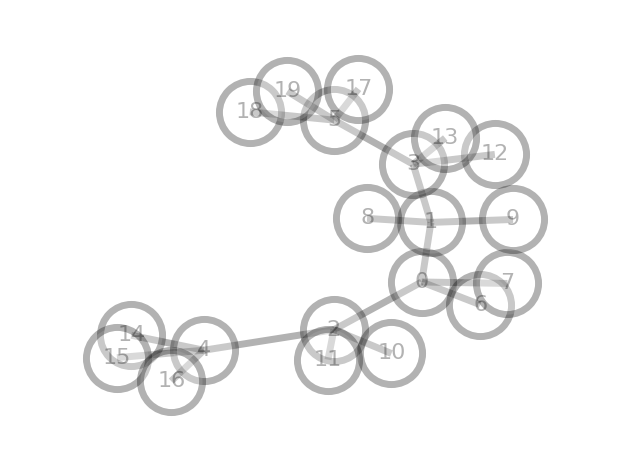

In [4]:
# Get molecules via Pupchem and visualize them

molecule1 = pcp.get_compounds(smiles1, "smiles", record_type='3d')[0]
molecule2 = pcp.get_compounds(smiles2, "smiles", record_type='3d')[0]
mol_list  = [molecule1,molecule2]

atoms          = [np.array([[a.x,a.y,a.z] for a in molecule.atoms]) for molecule in mol_list]
atom_names     = [np.array([a.element for a in molecule.atoms]) for molecule in mol_list]
mol_bond_list  = [[[b.aid1,b.aid2] for b in molecule.bonds] for molecule in mol_list]

for n,bl in zip(name_list,mol_bond_list):
    print("Molecule: %s"%n)
    vis_mol(bl)

Molecule: butylamine


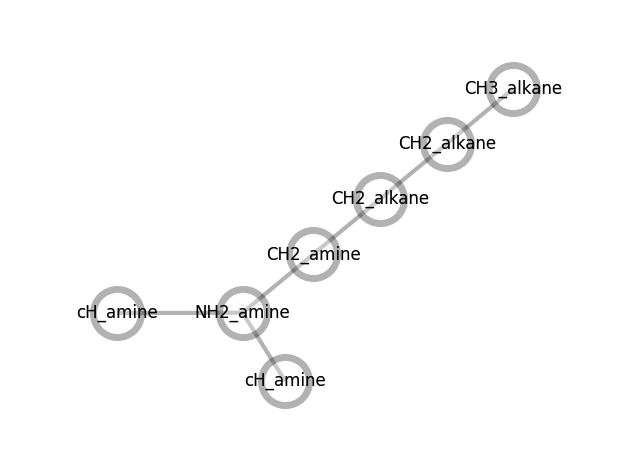

Molecule: hexane


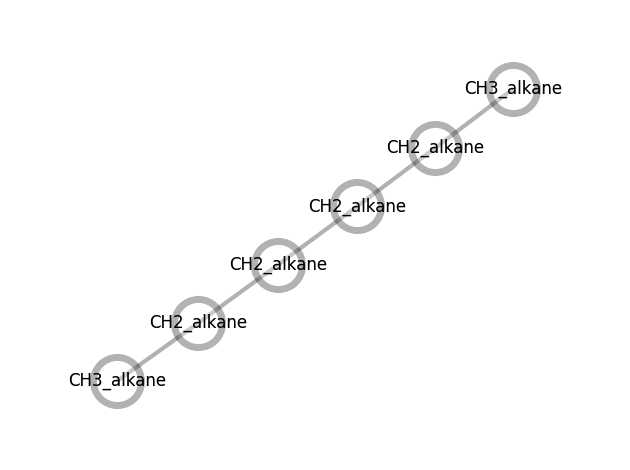

In [5]:
# get united atom pendand 
print("Molecule: %s"%name1)
raw_molecule1 = moleculegraph.molecule(molecule1_graphstring)
raw_molecule1.visualize()

print("Molecule: %s"%name2)
raw_molecule2 = moleculegraph.molecule(molecule2_graphstring)
raw_molecule2.visualize()

raw_mol_list  = [raw_molecule1,raw_molecule2]

bond_list = [np.array([[bb[0]-1,bb[1]-1] for bb in b]) for b in mol_bond_list]
atomtypes = [np.array([[mol.atoms[bb[0]-1].element,mol.atoms[bb[1]-1].element] for bb in b]) for mol,b in zip(mol_list,mol_bond_list)]

In [6]:
# TO DO:

#ADD that Methane can be understood

SyntaxError: invalid syntax (471372096.py, line 3)

In [7]:
UA = True
#UA = False

#Schreibe die United Atoms raus (entferne alle H's die an Kohlenstoffe gebunden sind)

cleaned_bond_list = []
cleaned_atomtypes = []

for atom,bonds in zip(atomtypes,bond_list):
    dummy1 = []
    dummy2 = []
    for (b0,b1),(a0,a1) in zip( bonds, atom):
        if UA:
            if all([x in (a0,a1) for x in ["H","C"]]):
                hydrogen = np.array([b0, b1])[ np.array([a0,a1]) == "H" ]
                print("C + H detected")                                   
                if bonds[ bonds == hydrogen ].size == 1:          
                    print("continue")                                     
                    continue
            print( "keep",b0,b1,"->",a0,"--",a1 )   
        dummy1.append((b0,b1))
        dummy2.append((a0,a1))
    cleaned_bond_list.append(np.array(dummy1))
    cleaned_atomtypes.append(np.array(dummy2))
    if UA: print("\n")

keep 0 3 -> N -- C
keep 0 14 -> N -- H
keep 0 15 -> N -- H
keep 1 2 -> C -- C
keep 1 3 -> C -- C
C + H detected
continue
C + H detected
continue
keep 2 4 -> C -- C
C + H detected
continue
C + H detected
continue
C + H detected
continue
C + H detected
continue
C + H detected
continue
C + H detected
continue
C + H detected
continue


keep 0 1 -> C -- C
keep 0 2 -> C -- C
C + H detected
continue
C + H detected
continue
keep 1 3 -> C -- C
C + H detected
continue
C + H detected
continue
keep 2 4 -> C -- C
C + H detected
continue
C + H detected
continue
keep 3 5 -> C -- C
C + H detected
continue
C + H detected
continue
C + H detected
continue
C + H detected
continue
C + H detected
continue
C + H detected
continue
C + H detected
continue
C + H detected
continue




In [8]:
new_cleaned_bond_list = []
new_idx = []

for cbl in cleaned_bond_list:
    ncbl,p = adjust_bond_list_indexes(cbl)
    new_cleaned_bond_list.append(ncbl)
    new_idx.append(p)
    
cleaned_coordinates = [atom[idx] for atom,idx in zip(atoms,new_idx)]
cleaned_atomtyps    = [atom_name[idx] for atom_name,idx in zip(atom_names,new_idx)]

# Create distance matrix of the molecule to type it to the moleculegraph definition used in further workflow

distance_matrix = []
for ncbl in new_cleaned_bond_list:
    dm,_ = get_distance_matrix(ncbl,np.unique(ncbl).size)
    distance_matrix.append(dm)
    
final_coordinates = []
final_idx         = []

for i,(mol,cc,dm) in enumerate(zip(raw_mol_list,cleaned_coordinates,distance_matrix)):
    
    names = cleaned_atomtyps[i]
    reference_names = [n.split("_")[0] for n in mol.atom_names]
    fc,idx = assign_coos_via_distance_mat_local(cc,dm,names,mol.distance_matrix,reference_names)
    final_coordinates.append(fc)
    final_idx.append(idx)
    
final_atomtyps = [ca[idx] for ca,idx in zip(cleaned_atomtyps,final_idx)]

# Write coordinates to xyz files. These coordinates are sorted in the way the molecule is defined in 
# the moleculegraph. This is important for step 2 of this workflow

if not os.path.exists("../inout_playmol/"+name_mix+"/"):
    os.makedirs("../inout_playmol/"+name_mix+"/")

# Build for pure and mixture the right system

systems = ["mix_%s_%s"%(name1,name1),"mix_%s_%s"%(name1,name2),"mix_%s_%s"%(name2,name1),"mix_%s_%s"%(name2,name2)]

for j,system in enumerate(systems):
    
    if not os.path.exists("../inout_playmol/"+name_mix+"/"+dict_key+"/"+system):
        os.makedirs("../inout_playmol/"+name_mix+"/"+dict_key+"/"+system)
    
    if j == 0:
        running_number = [np.arange(raw_molecule1.atom_number)+1,np.arange(raw_molecule1.atom_number)+1+raw_molecule1.atom_number]
        idx = [0,0]
    elif j == 1:
        running_number = [np.arange(raw_molecule1.atom_number)+1,np.arange(raw_molecule2.atom_number)+1+raw_molecule1.atom_number]
        idx = [0,1]
    elif j == 2:
        running_number = [np.arange(raw_molecule2.atom_number)+1,np.arange(raw_molecule1.atom_number)+1+raw_molecule2.atom_number]
        idx = [1,0]
    elif j == 3:
        running_number = [np.arange(raw_molecule2.atom_number)+1,np.arange(raw_molecule2.atom_number)+1+raw_molecule2.atom_number]
        idx = [1,1]
        
    n_list = system.split("_")[1:]

    for k,(i,name) in enumerate(zip(idx,n_list)):

        txt = [str(len(final_atomtyps[i]))+"\n","\n"]
        tmp = ["   ".join([fan+str(rn)]+[str(a) for a in fc])+"\n" for fan,rn,fc in zip(final_atomtyps[i],running_number[k],final_coordinates[i])]
        txt += tmp
        
        out = "../inout_playmol/"+name_mix+"/"+dict_key+"/"+system+"/"+name+"_playmol.xyz"

        with open(out, "w") as f:
            f.writelines(txt)
   



    Assign_coos_via_distance_mat is not mature yet.
    Double-check your results!!! 
 



    Assign_coos_via_distance_mat is not mature yet.
    Double-check your results!!! 
 

